## Problem definition: Simple classification of Brain images into MRI vs PET


In this jupyter notebook, we would like for you to build a basic classification model using convolutional neural netowrks to classify  T1 vs T2 weighted MRI images.

In order to enable ease of access we have converted all the DICOM formatted images into JPEG format and randomly sorted them into training and test set. 

In [ ]:
#Load packages
import numpy as np
import pandas as pd
import os
import math
import PIL
from pathlib import Path
import glob as gb
from collections import Counter

from tqdm import tqdm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

import matplotlib.pyplot as plt
import matplotlib.image as img

from google.colab import drive

Lets mount the drive 
we have already created a link to the data via shortcuts. The folder are arranged as such: 


> /content/drive/MyDrive/Module0/PROJ

>> /content/drive/MyDrive/Module0/PROJ/TRAIN

>>>/content/drive/MyDrive/Module0/PROJ/TRAIN/T1
>>>/content/drive/MyDrive/Module0/PROJ/TRAIN/T2
    
>>/content/drive/MyDrive/Module0/PTOJ/TEST

>>>>/content/drive/MyDrive/Module0/PROJ/TEST/T1
>>>>/content/drive/MyDrive/Module0/PROJ/TEST/T2



In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train= '/content/drive/MyDrive/Module0/PROJ/TRAIN/'
test = '/content/drive/MyDrive/Module0/PROJ/TEST/'

Lets check how many images there are under each label in training and validation sets

In [ ]:
num_T1_train_pts = len(gb.glob(train+'T1/*.jpg'))
num_T1_test_pts = len(gb.glob(test+'T1/*.jpg'))
print('There are {} T1 images in the training folder'.format(num_T1_train_pts)+'\n'+
      'and {} in the test folder'.format(num_T1_test_pts))


num_T2_train_pts = len(gb.glob(train+'T2/*.jpg'))
num_T2_test_pts = len(gb.glob(test+'T2/*.jpg'))
print('There are {} T2 images in the training folder'.format(num_T2_train_pts)+'\n'+
      'and {} images in the test folder'.format(num_T2_test_pts))

There are 3487 T1 images in the training folder
and 251 in the test folder
There are 3235 T2 images in the training folder
and 244 images in the test folder


use the function below for plotting the images in the grid.

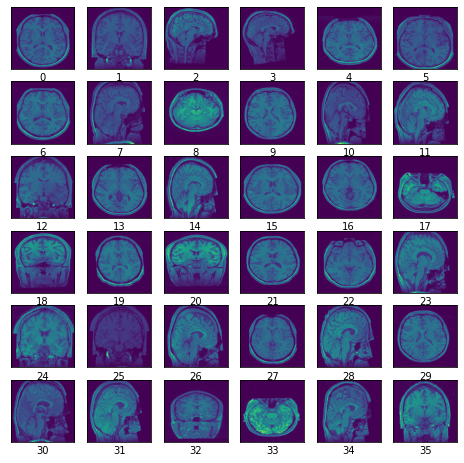

In [ ]:
T1_train = gb.glob(train+'T1/*.jpg')
T2_train = gb.glob(train+'T2/*.jpg')
T1_test = gb.glob(test+'T1/*.jpg')
T2_test = gb.glob(test+'T2/*.jpg')


def plot_grid(n,files):
  # takes argument n of the n x n grid and the list of files
  plt.figure(figsize=(8,8))
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #MRI images 
    idx=np.random.randint(len(files))
    plt.imshow(img.imread(files[idx]),aspect='auto')
    plt.xlabel(i)
  plt.show()


# lets plot mri_train
plot_grid(6,T1_train)

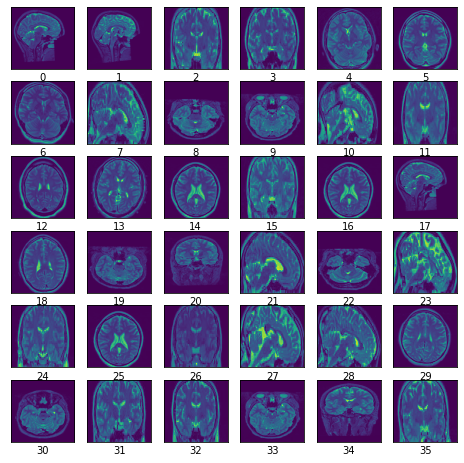

In [ ]:
plot_grid(6,T2_test)

Next, let's load these images off disk as an image-generator object from keras api. The *`ImageDataGenerator()`* class has a convinient function  `flow_from_directory()` utility that can infer the data classes based on the subfolders in the directory. In paractive *`ImageDataGenerator()`* can be used for data agumentation, but we will not be needing this at the moment. 

**Note** the target size parameter it is set to 256 X 256 which means we are asking Keras to read all the images at that resolution. This is also the dimensions of the first layer in your CNN, so if you would like for the training to run faster or slower you can tweak this parameter. But I reccomend not changing this. 

We will be splitting images in the train folder into 80% train and 20% validation set.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,validation_split=0.2) # set validation split
classes = ['T1', 'T2'] # class labels
image_size=(256,256) #image size
train_ds =  train_datagen.flow_from_directory(
  train,
  subset="training", 
  seed=123, 
  classes=classes,
  target_size=image_size,
  batch_size=32,
  interpolation="lanczos")

Found 5378 images belonging to 2 classes.


Enter the code block for valdiation data

In [ ]:
valid_ds = train_datagen.flow_from_directory(
  train,
  subset="validation", seed=123, 
  classes=classes,
  target_size=image_size,
  batch_size=32,
  interpolation="lanczos")

Found 1344 images belonging to 2 classes.


In [ ]:
# Test set will not be shown to the model 
#it will be used to calculate performance on the trained model
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_ds = test_datagen.flow_from_directory(test, classes=classes,target_size=image_size,batch_size=500,shuffle=False)

Found 495 images belonging to 2 classes.


These 495 images will be your independent test set which will be used to test our model performance.

**Use the functions below to get the perfromance of the model**

In [ ]:
def training_performance(history,epochs,metric_list):
  ## Takes history and metric_list, returns figure object
  metric_list.append('loss')
  train_metric = {}
  valid_metric = {}
  epoch_ranges = range(epochs)
  n_metric = len(metric_list)
  fig = plt.figure(figsize=(5*n_metric, 4))
  j = 1
  for i in metric_list:
    train_metric[i] = history.history[i]
    valid_metric[i] = history.history['val_{}'.format(i)]
    plt.subplot(1,n_metric,j)
    plt.plot(epoch_ranges,train_metric[i], label='Training_{}'.format(i))
    plt.plot(epoch_ranges,valid_metric[i], label='Validation_{}'.format(i))
    plt.legend(loc='lower right')
    plt.title('Training_Valdiation_{}'.format(i)) 
    j+=1
  return fig

def test_performance(y_test,y_pred):
  ## Takes test labels and predicted lables returns 
  ## Returns confusion matrix plot, ROC, PR plots 
  from sklearn.metrics import classification_report,confusion_matrix, \
                              ConfusionMatrixDisplay, accuracy_score, auc
  from sklearn.metrics import roc_curve as roc
  from sklearn.metrics import RocCurveDisplay
  from sklearn.metrics import precision_recall_curve as pr
  from sklearn.metrics import PrecisionRecallDisplay as prd

  target_names = ['T1', 'T2']
  fig,axes = plt.subplots(1, 3, figsize=(16, 4))
  ## Confusion Matrix
  cm = confusion_matrix(y_test,y_pred)
  print("Confusion Matrix \n \
         \n T1 \t {} \
         \n T1_Predicted_as_T2 \t {} \
         \n T2_Predicted_as_T1 \t {} \
         \n T2 \t {} \n".format(cm[0][0],cm[0][1],cm[1][0],cm[1][1]))

  print ("Overall Accuracy of the model: {:.3f}".format(accuracy_score \
                                          (y_test,y_pred)))
  cmd = ConfusionMatrixDisplay(cm, display_labels=target_names) 
  cmd.plot(ax=axes[0])
  cmd.ax_.set(xlabel='Predicted', ylabel='Test', \
            title='Confusion matrix' )
  cmd.im_.colorbar.remove()
  ## ROC curve
  fpr, tpr, thresholds = roc(y_test,y_pred)
  auroc = auc(fpr,tpr)
  roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, \
                           roc_auc=auroc,estimator_name='CNN_T1_T2')
  roc_plot.plot(ax=axes[1])
  roc_plot.ax_.set(xlabel='False Postive Rate', ylabel='True Postive Rate')
  roc_plot.figure_.suptitle('ROC')

  ## Precision-Recall
  precision, recall, _ = pr(y_test,y_pred)
  auprc = auc(recall,precision)
  pr_plot = prd(precision=precision, recall=recall)
  pr_plot.plot(ax=axes[2],name='PR AUC={:.3f}'.format(auprc))
  pr_plot.ax_.set(xlabel='Recall', ylabel='Precision')
  pr_plot.figure_.suptitle('Precision-Recall Curve')

  return fig

Let's continue with the model...

In [ ]:
model = Sequential([
  layers.InputLayer(input_shape=(256,256,3)),
  layers.Conv2D(32,(3,3),activation='relu', padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64,(3,3),activation='relu'),
  layers.Conv2D(128,(3,3),activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(32,activation='relu'),
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 492032)           

Lets look at the summary of the model we specified.

Let's compile the model. We have to pick an optimizer and loss function to compile the model. For this tutorial, choose the `tf.keras.optimizers.Adam `optimizer and `tf.keras.losses.BinaryCrossentropy` loss function. This loss function is ideal for scienarios where we only have 2 classes in the dataset. To view training and validation accuracy for each training epoch, pass the metrics argument to `Model.compile`. You can read more about these options here:

> https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam 
> https://www.tensorflow.org/api_docs/python/tf/keras/losses/

These are also some parameters you can play with to see how the performance of the model changes. Finally the metrics parameter specifies how we want to frame the problem. Recall the introduction. Lets pick accuracy which is a balance between both the classes.

In [ ]:
# lr = 0.0001
num_steps_per_epoch = 60
num_validation_steps = 20
num_epochs = 3
model.compile(#Adam(learning_rate = lr),
              # optimizer='adam',
              optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Train the model in 10 epochs

In [ ]:
history = model.fit(
  train_ds,
  steps_per_epoch=num_steps_per_epoch,
  validation_data=valid_ds, 
  validation_steps=num_validation_steps,
  epochs=num_epochs, verbose=2
)

Epoch 1/3
60/60 - 59s - loss: 0.5453 - accuracy: 0.7427 - val_loss: 0.3668 - val_accuracy: 0.8156 - 59s/epoch - 987ms/step
Epoch 2/3
60/60 - 41s - loss: 0.1566 - accuracy: 0.9521 - val_loss: 0.0566 - val_accuracy: 0.9969 - 41s/epoch - 685ms/step
Epoch 3/3
60/60 - 33s - loss: 0.0405 - accuracy: 0.9915 - val_loss: 0.0183 - val_accuracy: 0.9984 - 33s/epoch - 546ms/step


Lets check how the model has trained. We can do this by plotting the accuracy between traing data and validation data

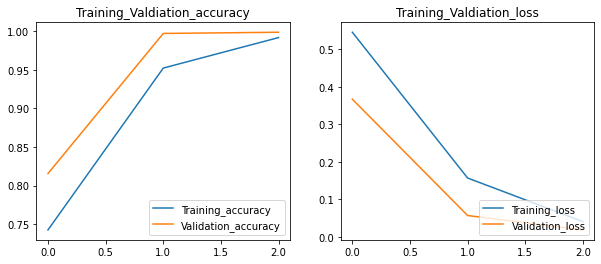

In [ ]:
a = training_performance(history,num_epochs,['accuracy'])

get test lables 

In [ ]:
y_test = test_ds.labels

make predictions

In [ ]:
predictions = model.predict(x=test_ds, verbose=1)

1/1 [==============================] - 1s 1s/step


Evaluate using model.evaluate()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds,
                                     steps=1)
                                     #verbose=0) 
print(test_loss)
print(test_acc) 

1/1 [==============================] - 2s 2s/step - loss: 0.0742 - accuracy: 0.9859
0.07423999160528183
0.9858585596084595


In [ ]:
y_pred = np.round(predictions[:,1])

Confusion Matrix 
          
 T1 	 249          
 T1_Predicted_as_T2 	 2          
 T2_Predicted_as_T1 	 5          
 T2 	 239 

Overall Accuracy of the model: 0.986


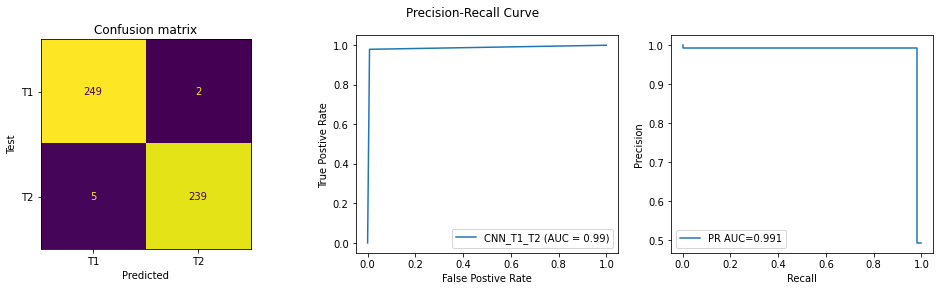

In [ ]:
b = test_performance(y_test,y_pred)